In [4]:
import os
import pandas as pd
import numpy as np
import pickle
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
city = 'frankfurt'
db = "0.50"
OC = 1.5

In [6]:
directory = '../../raw_results'
file_names = os.listdir(directory)

# https://www.gurobi.com/documentation/current/refman/optimization_status_codes.html
status_map = {2: 'optimal', 9: 'time_limit', 11: 'interrumpted'}

results = []

for i in range(len(file_names)):
    results_file = f'{directory}/{file_names[i]}'
    with open(results_file, 'rb') as file:
        sol = pickle.load(file)
    keys = file_names[i].split('_')
    final_sol = {
        'city': keys[0],
        'db': keys[1].replace('db=', ''),
        'OC': keys[2].replace('OC=', ''),
        'model': keys[3].replace('model=', '').replace('.pkl', ''),
        'max_n_shifts': keys[-1].replace('shifts=', '').replace('.pkl', '') if 'shifts' in keys[-1] else "",
        'obj_val': sol['obj_val'], 
        'status': status_map[sol['status']], 
        'gap': np.round(float(sol['gap']) * 100, 2),
        'workforce_size': len(sol['U'])
    }
    results.append(final_sol)

results_df = pd.DataFrame(results)
results_df['model_'] = results_df['model'] + results_df['max_n_shifts']
results_df = results_df.query(f'city == "{city}"').sort_values(['db', 'OC', 'model'])

model_results = pd.pivot_table(results_df, index=['city', 'db', 'OC'], 
    values=['obj_val', 'workforce_size'], columns='model_').astype(int)
model_results

obj_val                                     workforce_size  \
model_          fixed  flex partflex2 partflex3 partflex4          fixed   
city db   OC                                                               
lyon 0.50 1.2    1536  1381      1536      1381      1381            130   
          1.5    1608  1469      1608      1469      1469            118   
          1.8    1648  1554      1648      1554      1554            130   
          2.0    1676  1628      1676      1628      1628            130   
          2.5    1741  1686      1741      1686      1686            130   
     1.00 1.2    2709  2327      2709      2327      2327            216   
          1.5    2798  2409      2798      2409      2409            216   
          1.8    2880  2448      2880      2448      2448            216   
          2.0    2918  2473      2918      2473      2473            224   
          2.5    3017  2532      3017      2532      2532            224   
     2.00 1.2    4935  4160      4935      4160      4160            382   
          1.5    5082  4256      5082      4256      4256            398   
          1.8    5195  4336      5195      4336      4336            406   
          2.0    5256  4382      5256      4382      4382            414   
          2.5    5381  4453      5381      4453      4453            450   
     4.00 1.2    9449  7775      9449      7775      7775            746   
          1.5    9686  7904      9686      7904      7904            790   
          1.8    9869  8025      9869      8025      8025            808   
          2.0    9977  8071      9977      8071      8071            808   
          2.5   10153  8195     10153      8195      8195            852   

                                                   
model_         flex partflex2 partflex3 partflex4  
city db   OC                                       
lyon 0.50 1.2   150       130       150       150  
          1.5   151       118       151       151  
          1.8   161       130       161       161  
          2.0   154       130       154       154  
          2.5   145       130       145       145  
     1.00 1.2   270       216       270       270  
          1.5   270       216       270       270  
          1.8   294       216       294       294  
          2.0   306       224       306       306  
          2.5   336       224       336       336  
     2.00 1.2   480       382       480       480  
          1.5   531       398       531       531  
          1.8   531       406       531       531  
          2.0   531       414       531       531  
          2.5   573       450       573       573  
     4.00 1.2   933       746       933       933  
          1.5   978       790       978       978  
          1.8   990       808       990       990  
          2.0  1041       808      1041      1041  
          2.5  1080       852      1080      1080

In [7]:
# save table to latex
latex_table = model_results.reset_index().drop('city', axis='columns')#.to_latex(index=False, multicolumn=False)
latex_table

<ipython-input-7-ed1547e351eb>:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  latex_table = model_results.reset_index().drop('city', axis='columns')#.to_latex(index=False, multicolumn=False)


db   OC obj_val                                     workforce_size  \
model_              fixed  flex partflex2 partflex3 partflex4          fixed   
0       0.50  1.2    1536  1381      1536      1381      1381            130   
1       0.50  1.5    1608  1469      1608      1469      1469            118   
2       0.50  1.8    1648  1554      1648      1554      1554            130   
3       0.50  2.0    1676  1628      1676      1628      1628            130   
4       0.50  2.5    1741  1686      1741      1686      1686            130   
5       1.00  1.2    2709  2327      2709      2327      2327            216   
6       1.00  1.5    2798  2409      2798      2409      2409            216   
7       1.00  1.8    2880  2448      2880      2448      2448            216   
8       1.00  2.0    2918  2473      2918      2473      2473            224   
9       1.00  2.5    3017  2532      3017      2532      2532            224   
10      2.00  1.2    4935  4160      4935      4160      4160            382   
11      2.00  1.5    5082  4256      5082      4256      4256            398   
12      2.00  1.8    5195  4336      5195      4336      4336            406   
13      2.00  2.0    5256  4382      5256      4382      4382            414   
14      2.00  2.5    5381  4453      5381      4453      4453            450   
15      4.00  1.2    9449  7775      9449      7775      7775            746   
16      4.00  1.5    9686  7904      9686      7904      7904            790   
17      4.00  1.8    9869  8025      9869      8025      8025            808   
18      4.00  2.0    9977  8071      9977      8071      8071            808   
19      4.00  2.5   10153  8195     10153      8195      8195            852   

                                            
model_  flex partflex2 partflex3 partflex4  
0        150       130       150       150  
1        151       118       151       151  
2        161       130       161       161  
3        154       130       154       154  
4        145       130       145       145  
5        270       216       270       270  
6        270       216       270       270  
7        294       216       294       294  
8        306       224       306       306  
9        336       224       336       336  
10       480       382       480       480  
11       531       398       531       531  
12       531       406       531       531  
13       531       414       531       531  
14       573       450       573       573  
15       933       746       933       933  
16       978       790       978       978  
17       990       808       990       990  
18      1041       808      1041      1041  
19      1080       852      1080      1080

In [8]:
model_results_ = pd.pivot_table(results_df, index=['city', 'db', 'OC'], 
    values='obj_val', columns='model_').astype(int)

display(model_results_.query('fixed < partflex3'))
display(model_results_.query('fixed < partflex4'))

,,model_,fixed,flex,partflex2,partflex3,partflex4
city,db,OC,,,,,


,,model_,fixed,flex,partflex2,partflex3,partflex4
city,db,OC,,,,,


In [9]:
directory = '../../raw_results'
file_names = [file for file in os.listdir(directory) if f'{city}_db={db}_OC={OC}' in file]
file_names

['lyon_db=0.50_OC=1.5_model=partflex_max_n_shifts=4.pkl',
 'lyon_db=0.50_OC=1.5_model=partflex_max_n_shifts=3.pkl',
 'lyon_db=0.50_OC=1.5_model=partflex_max_n_shifts=2.pkl',
 'lyon_db=0.50_OC=1.5_model=flex.pkl',
 'lyon_db=0.50_OC=1.5_model=fixed.pkl']

In [10]:
solution_file = 'paris_db=1.00_OC=1.5_model=partflex_max_n_shifts=3.pkl'
with open(f'{directory}/{solution_file}', 'rb') as file:
    solution = pickle.load(file)

area_assignment = [ (key[0], key[1], key[2], key[3]) for key, value in solution['k'].items() ]
area_assignment_df = pd.DataFrame(area_assignment, columns=['employee', 'area_id', 'period', 'day'])
area_period_summary = area_assignment_df.groupby(['area_id', 'day', 'period']).count().reset_index()
area_period_summary['day_period'] = area_period_summary['day'].astype(str) + '\n' + area_period_summary['period'].astype(str)

In [11]:
def data_prepare(solution, subset_areas=None):
    area_assignment = [ (key[0], key[1], key[2], key[3]) for key, value in solution['k'].items() ]
    area_assignment_df = pd.DataFrame(area_assignment, columns=['employee', 'area_id', 'period', 'day'])
    area_period_summary = area_assignment_df.groupby(['area_id', 'day', 'period']).count().reset_index()
    #area_period_summary['day_period'] = area_period_summary['day'].astype(str) + '\n' + area_period_summary['period'].astype(str)
    area_period_summary['day_period'] = area_period_summary['day'].astype(str) + '-' + area_period_summary['period'].astype(str)

    # Subset area
    if subset_areas is not None:
        area_period_summary = area_period_summary[area_period_summary['area_id'].apply(lambda x: x in subset_areas)]

    return area_period_summary

In [12]:
def plot_area_periods(solution_file, area_period_summary):
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(30,10))

    pt = pd.pivot(area_period_summary, index="area_id", columns='day_period', values="employee")
    sns.heatmap(pt, annot=True, ax=axs, cbar=False, cmap='Blues')

    model_ = solution_file.split('model=')[1]
    if 'max_n' in model_:
        model = model_.split('_max')[0].split('.')[0].upper() + f' (max number of shifts = { model_.split("max_n_shifts=")[1].replace(".pkl","") })'
    else:
        model = model_.split('_max')[0].split('.')[0].upper()

    city = solution_file.split('_')[0].upper()
    db = solution_file.split('db=')[1].split('_')[0]
    oc = solution_file.split('OC=')[1].split('_')[0]
    title = city + ' DB=' + db + ' OC=' + oc + '\n' + model

    axs.set_title(title, fontsize=16)
    axs.set_ylabel('Areas', fontsize=16)
    axs.set_xlabel('Time', fontsize=16)
    plt.yticks(rotation=0)

    plt.show()

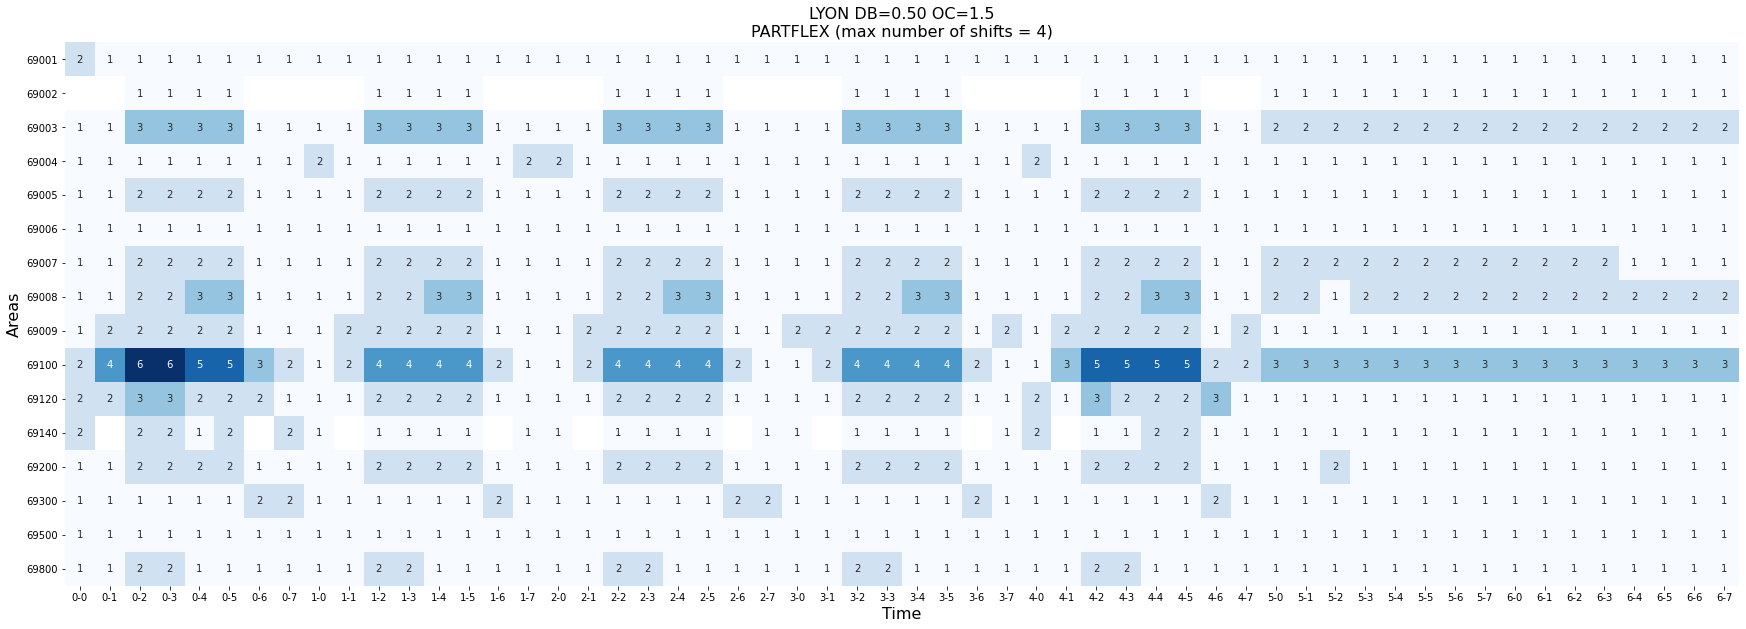

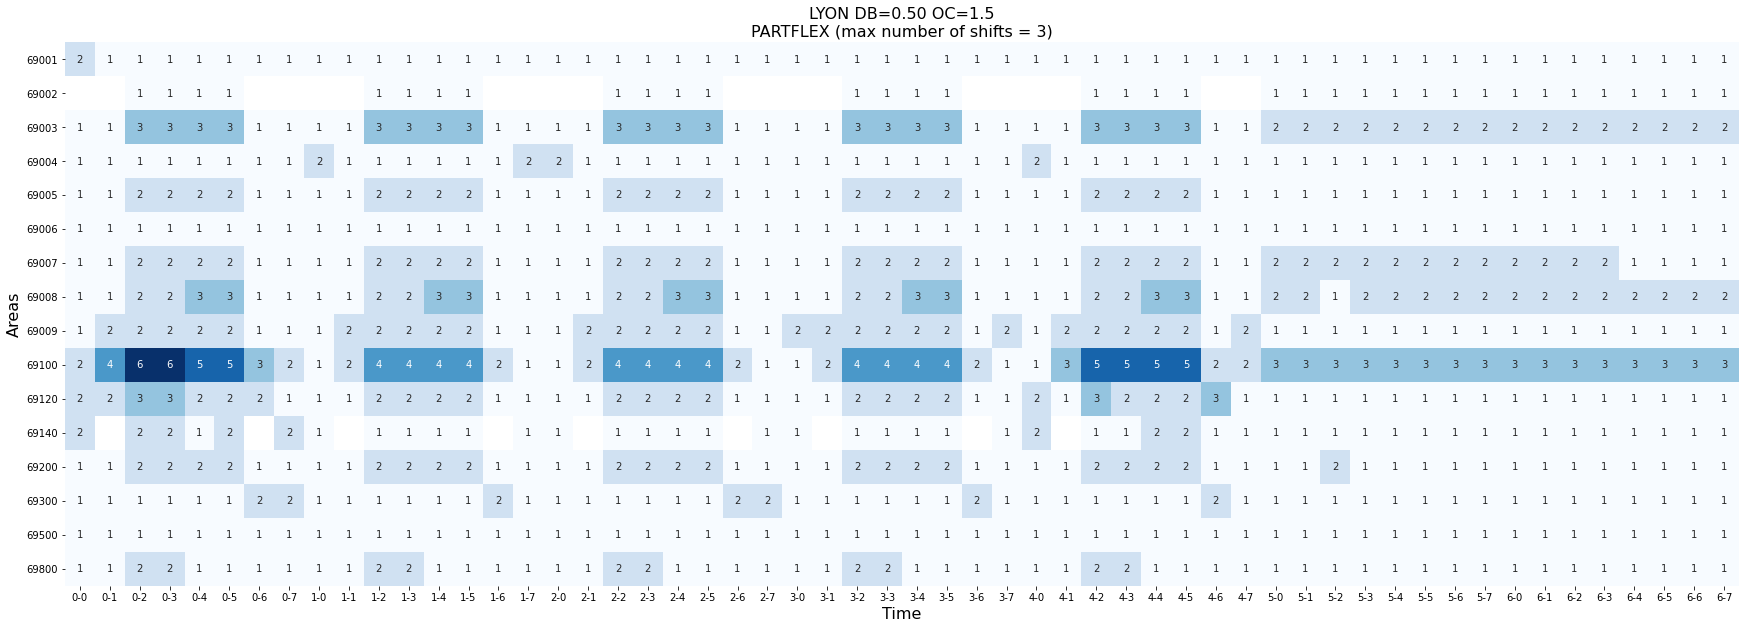

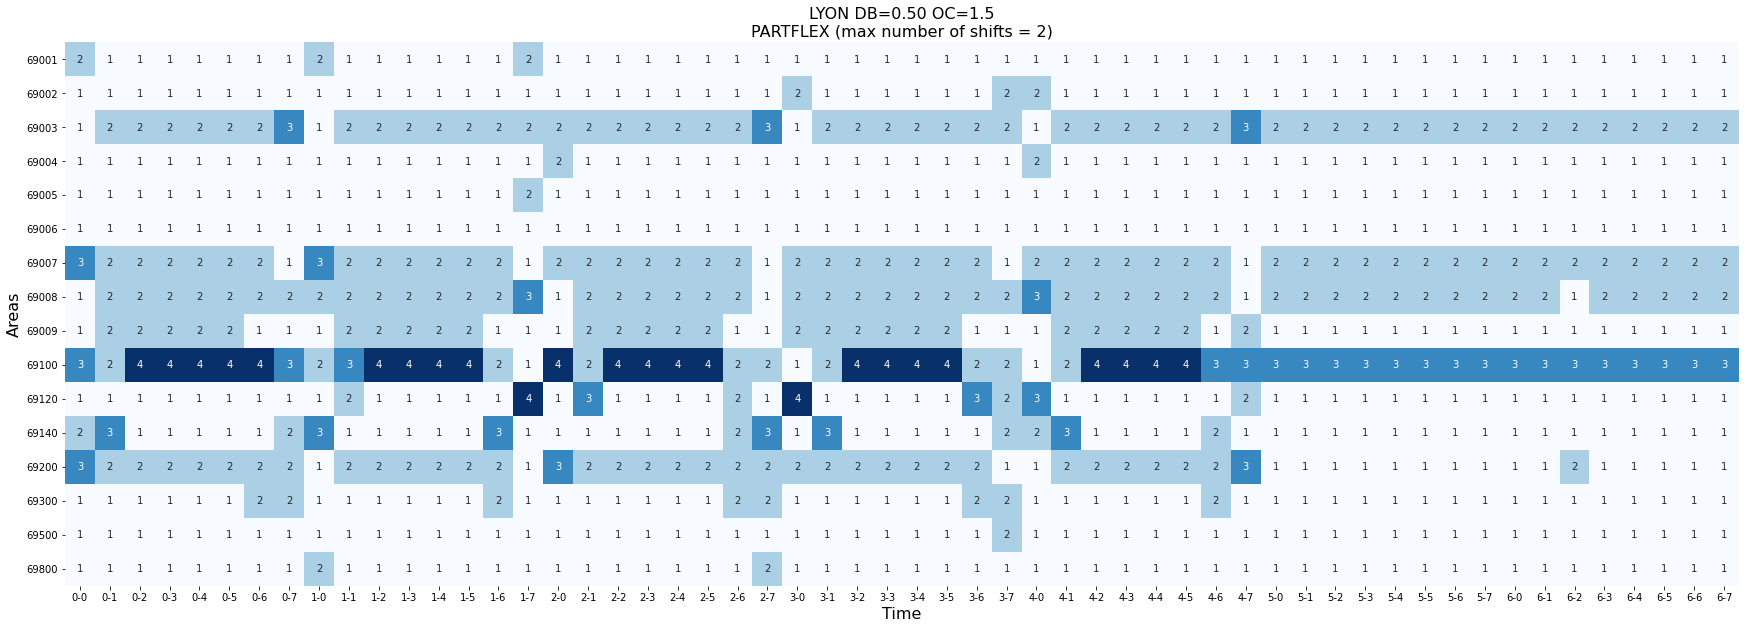

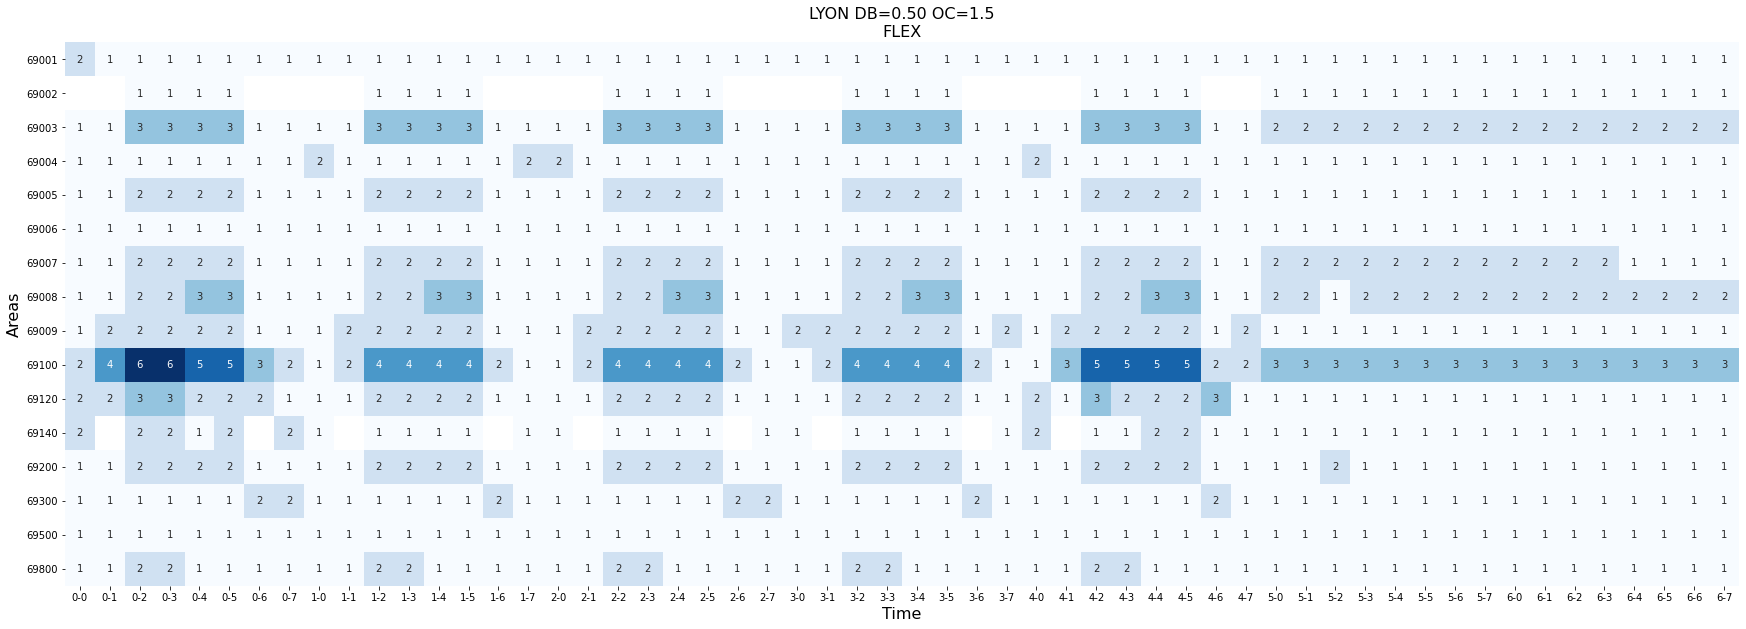

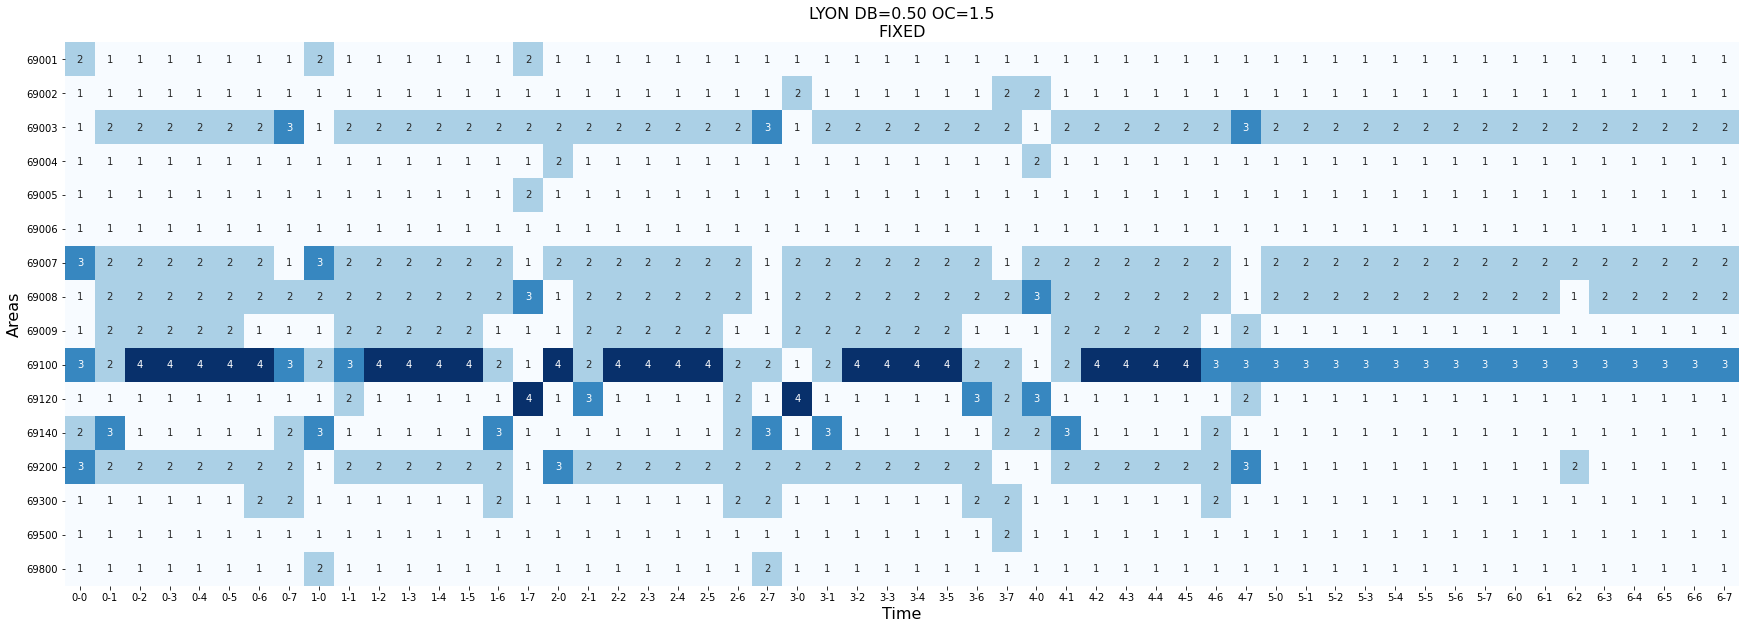

In [13]:
for solution_file in file_names:
    # Data preparation
    with open(f'{directory}/{solution_file}', 'rb') as file:
        solution = pickle.load(file)
    # subset_areas = solution['reg_areas'][0]
    area_period_summary = data_prepare(solution, subset_areas=None)
    plot_area_periods(solution_file, area_period_summary)

# DEMAND

In [14]:
def __load_instance(instance_file: str) -> dict:
    with open(instance_file) as f:
        return json.load(f)

i_weekday = __load_instance(f'../../instances/{city}_db={db}_dt=doublepeak.json')
i_weekend = __load_instance(f'../../instances/{city}_db={db}_dt=uniform.json')

sdemand, srequired = dict(), dict()

for day in range(7):
    if day in [0,1,2,3,4]:
        #weekday
        for scenario in i_weekday['scenarios']:
            s = scenario['scenario_num']
            for data in scenario['data']:
                a = data['area_id']
                for theta, d in enumerate(data['demand']):
                    sdemand[(s, a, theta, day)] = d

                for theta, m in enumerate(data['required_couriers']):
                    srequired[(s, a, theta, day)] = m
        else:
            #weekend
            for scenario in i_weekend['scenarios']:
                s = scenario['scenario_num']
                for data in scenario['data']:
                    a = data['area_id']
                    for theta, d in enumerate(data['demand']):
                        sdemand[(s, a, theta, day)] = d

                    for theta, m in enumerate(data['required_couriers']):
                        srequired[(s, a, theta, day)] = m

In [15]:
deliveries_df = (
    pd.DataFrame([ [s[0], s[1], s[2], s[3], v] for s, v in sdemand.items()],
        columns = ['scenario', 'area_id', 'period', 'day', 'deliveries']
    )
)

deliveries_df_ = (
    deliveries_df
    .groupby(['area_id', 'period', 'day',])
    .agg({'deliveries': 'median'})
    .reset_index()
)

deliveries_df_['day_period'] = deliveries_df_['day'].astype(str) + '-' + deliveries_df_['period'].astype(str)

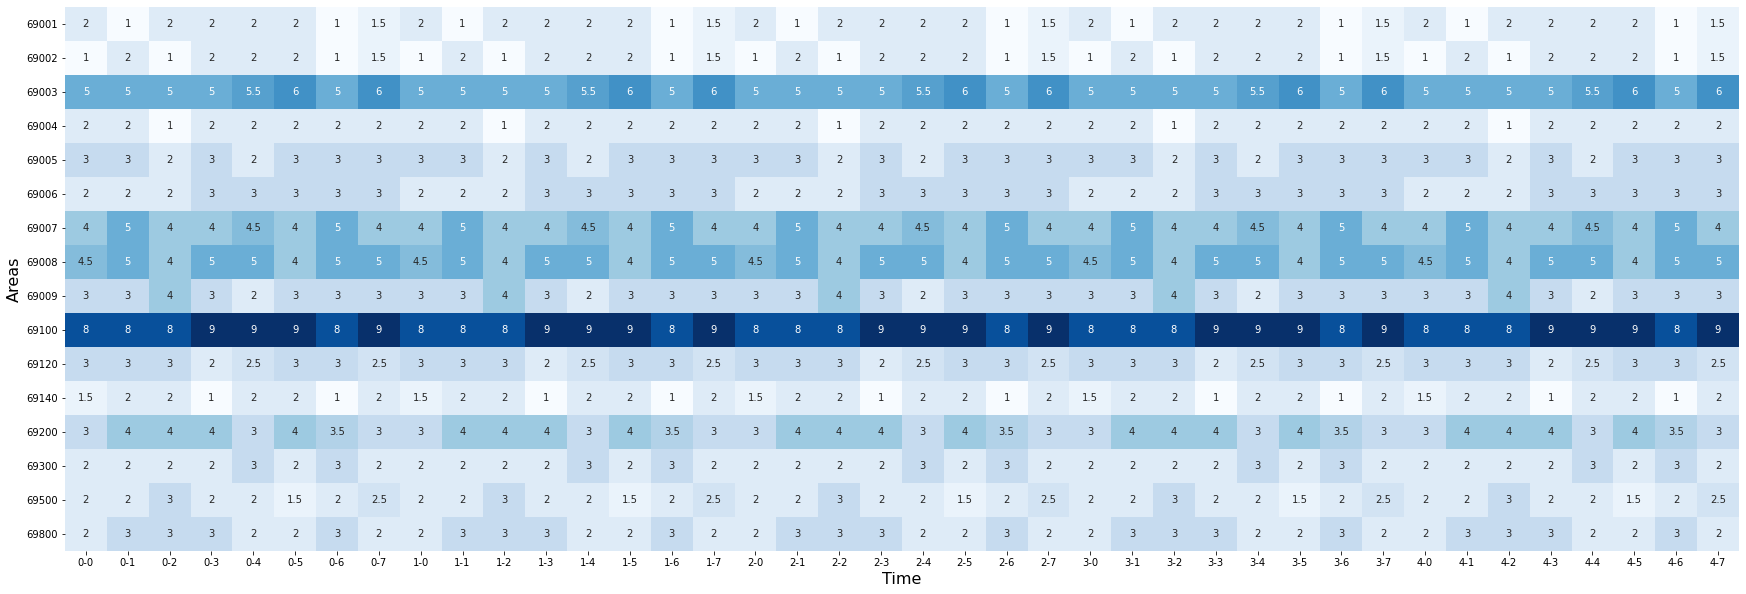

In [16]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(30,10))

pt = pd.pivot(deliveries_df_, index="area_id", 
    columns='day_period', values='deliveries')
sns.heatmap(pt, annot=True, ax=axs, cbar=False, cmap='Blues')

title = ""
axs.set_title(title, fontsize=16)
axs.set_ylabel('Areas', fontsize=16)
axs.set_xlabel('Time', fontsize=16)
plt.yticks(rotation=0)

plt.show()

In [17]:
# Population in each area
area_population = []
for region in i_weekday['geography']['city']['regions']:
    for area in region['areas']:
        #area['region_id'] = region
        area_population.append(area)
pd.DataFrame(area_population)

,id,population,surface_area,avg_distance_to_depot
0,69009,48546.0,8.02,1.552
1,69001,28755.0,1.41,0.523
2,69004,34988.0,2.79,0.771
3,69006,49088.0,3.67,0.798
4,69300,41209.0,10.48,1.342
5,69100,145150.0,14.69,1.631
6,69120,41421.0,21.40,2.167
7,69140,29952.0,14.97,1.704
8,69008,78793.0,6.80,1.049
9,69200,59855.0,15.76,1.657


In [18]:
couriers_df = (
    pd.DataFrame([ [s[0], s[1], s[2], s[3], v] for s, v in srequired.items()],
        columns = ['scenario', 'area_id', 'period', 'day', 'required_couriers']
    )
)

couriers_df_ = (
    couriers_df
    .groupby(['area_id', 'period', 'day',])
    .agg({'required_couriers': 'median'})
    .reset_index()
)

couriers_df_['day_period'] = couriers_df_['day'].astype(str) + '-' + couriers_df_['period'].astype(str)

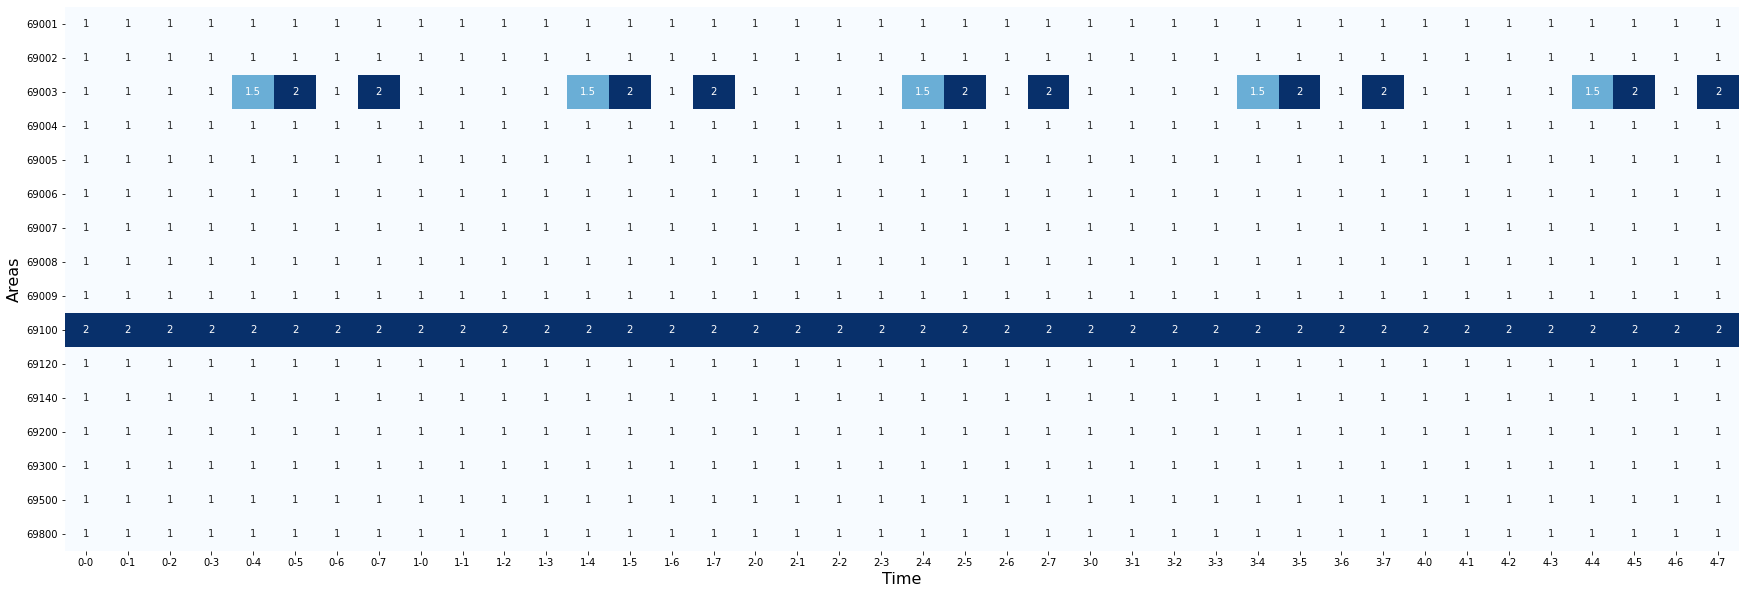

In [19]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(30,10))

pt = pd.pivot(couriers_df_, index="area_id", 
    columns='day_period', values='required_couriers')
sns.heatmap(pt, annot=True, ax=axs, cbar=False, cmap='Blues')

title = ""
axs.set_title(title, fontsize=16)
axs.set_ylabel('Areas', fontsize=16)
axs.set_xlabel('Time', fontsize=16)
plt.yticks(rotation=0)

plt.show()